# **Tiny Imagenet - Super Resolution**

We will be working on super-resolution and not classification tasks in this NB.

In [1]:
import timm, torch, random, datasets, math, fastcore.all as fc, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim
from torchvision.io import read_image,ImageReadMode

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *
from miniai.training import *

In [2]:
from fastprogress import progress_bar
from glob import glob
import warnings; warnings.filterwarnings('ignore')

In [3]:
torch.set_printoptions(precision=5, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['figure.dpi'] = 70

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## **Data Processing**

Copying over sections from the previous NBs.

In [4]:
path_data = Path('data')
path = path_data/'tiny-imagenet-200'
bs = 512
xmean,xstd = (tensor([0.47565, 0.40303, 0.31555]), tensor([0.28858, 0.24402, 0.26615]))

In [5]:
path

Path('data/tiny-imagenet-200')

**For tasks like super-resolution (and image reconstruction in general) we must ensure that both the dependant and independant data receive the same amount of data augmentation.** 

In [6]:
tfms = nn.Sequential(T.Pad(8), T.RandomCrop(64), T.RandomHorizontalFlip())

In [7]:
class TinyDS:
    def __init__(self, path):
        self.path = Path(path)
        self.files = glob(str(path/'**/*.JPEG'), recursive=True)
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        img = read_image(self.files[i], mode=ImageReadMode.RGB)/255
        return tfms((img-xmean[:,None,None])/xstd[:,None,None])

class TfmDS:
    def __init__(self, ds, tfmx=fc.noop, tfmy=fc.noop): self.ds,self.tfmx,self.tfmy = ds,tfmx,tfmy
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        item = self.ds[i]
        return self.tfmx(item),self.tfmy(item)

def denorm(x): return (x*xstd[:,None,None]+xmean[:,None,None]).clamp(0,1)

- We will add random erasing just for the training set. This makes the task of learning more difficult for the model and forces it to learn to replace missing pixels.
- In `TfmDS` the argument `tfmx` applies transformations / augmentations to the independant variable. In turn `tfmx()` applies `TF.resize()` to the 32x32 image, making it 64x64 and interpolates. This effectively doubles up the pixel count. 

In [8]:
# We will add random erasing just for the training set. This makes the task of learning more
# difficult for the model and forces it to learn to replace missing pixels.
def tfmx(x, erase=True):
    x = TF.resize(x, (32,32))[None]
    x = F.interpolate(x, scale_factor=2)
    if erase: x = rand_erase(x)
    return x[0]

In [9]:
tds = TinyDS(path/'train')
vds = TinyDS(path/'val')

tfm_tds = TfmDS(tds, tfmx)
tfm_vds = TfmDS(vds, partial(tfmx, erase=False))

dls = DataLoaders(*get_dls(tfm_tds, tfm_vds, bs=bs, num_workers=8))

In [10]:
xb,yb = next(iter(dls.train))

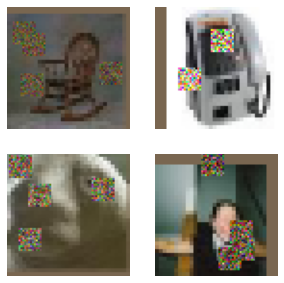

In [11]:
show_images(denorm(xb[:4]), imsize=2.5)

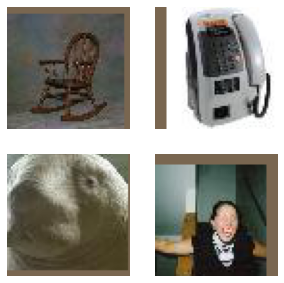

In [12]:
show_images(denorm(yb[:4]), imsize=2.5)

## **Implementing a Denoising AutoEncoder**

The `upblock` basically doubles the pixels through sequential upsampling. This is followed by an extra Resblock at the end to return 3 channels.

So this model basically takes images which are squeezed into smaller representations, and then these representations are brought back up to their super-resolution target. 

In [13]:
def upblock(ni, nf, ks=3, act=act_gr, norm=None):
    return nn.Sequential(nn.UpsamplingNearest2d(scale_factor=2),
                         ResBlock(ni, nf, ks=ks, act=act, norm=norm))

In [14]:
def get_model(act=act_gr, nfs=(32, 64, 128, 256, 512, 1024), norm=nn.BatchNorm2d, drop=0.1):
    layers = [ResBlock(3, nfs[0], ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) 
               for i in range(len(nfs)-1)]
    layers += [upblock(nfs[i], nfs[i-1], act=act, norm=norm) 
               for i in range(len(nfs)-1, 0, -1)]
    layers += [ResBlock(nfs[0], 3, act=nn.Identity, norm=norm)]
    return nn.Sequential(*layers).apply(iw)

In [15]:
iw = partial(init_weights, leaky=0.1)

In [16]:
metrics = MetricsCB()
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), MixedPrecision()]
lr_cbs = [DeviceCB(), ProgressCB(), MixedPrecision()]
opt_func = partial(optim.AdamW, eps=1e-5)

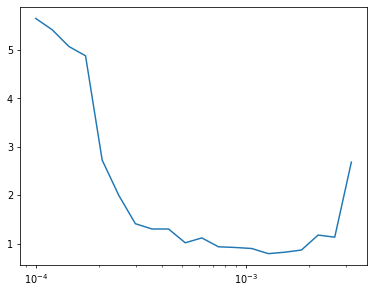

In [20]:
Learner(get_model().apply(iw), dls, F.mse_loss, cbs=lr_cbs, 
        opt_func=opt_func).lr_find(start_lr=1e-4, gamma=1.2)

In [17]:
epochs = 5
lr = 1e-3
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(get_model().apply(iw), dls, F.mse_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.586,0,train
0.373,0,eval
0.317,1,train
0.278,1,eval
0.254,2,train
0.229,2,eval
0.229,3,train
0.210,3,eval
0.222,4,train
0.208,4,eval


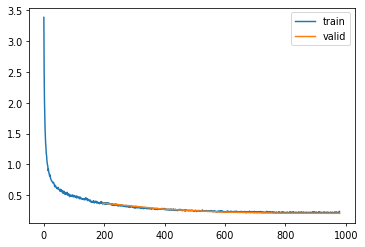

In [22]:
learn.fit(epochs)

loss,epoch,train
0.208,0,eval


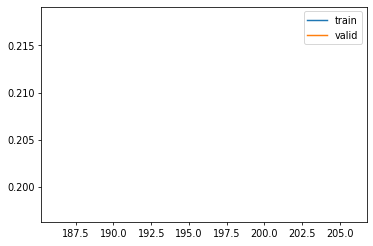

In [23]:
# predictions, targets and inputs extracted from the model
p, t, inp = learn.capture_preds(inps=True)

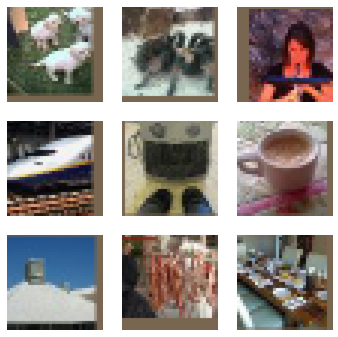

In [24]:
show_images(denorm(inp[:9]), imsize=2)

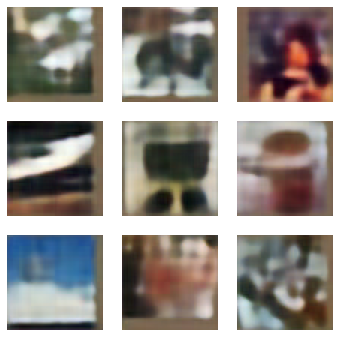

In [25]:
show_images(denorm(p[:9]), imsize=2)

These results are quite bad!!

The fundamental problem lies with the AutoEncoder, especially smaller AutoEncoders to carry out the task of super-resolution.

Instead of adding additional complexity, we can instead simplify the model using the UNet architecture.

## **Switching Over To A UNET**

In [18]:
del(learn)
clean_mem()

The [original paper](https://arxiv.org/abs/1505.04597) which introduced UNets in 2015, for use in medical imaging describes the architecture consisting... 

>.. of a contracting path to capture context and a symmetric expanding path that enables precise localization.

We have referred to the "contracting path" as the **downsampling path** in previous NBs. Conversely, the "symmetric expanding path" is referred to as the **upsampling path**. The original paper used Convolution blocks in both upsampling and downsampling paths, whereas we have used ResNet blocks.

During each stage of the upsampling path, the architecture copies over the activations from the opposite downsampling path. This ensures that the structure of the original image is retained for our super-resolution exercise.

In [28]:
class TinyUnet(nn.Module):
    def __init__(self, act=act_gr, nfs=(32, 64, 128, 256, 512, 1024),
                norm=nn.BatchNorm2d):
        super().__init__()
        self.start = ResBlock(3, nfs[0], stride=1, act=act, norm=norm)
        # Downsampling path
        self.dn = nn.ModuleList([ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
                                 for i in range(len(nfs)-1)])
        # Upsampling path
        self.up = nn.ModuleList([upblock(nfs[i], nfs[i-1], act=act, norm=norm)
                                 for i in range(len(nfs)-1, 0, -1)])
        # Final 3 channel block
        self.up += [ResBlock(nfs[0], 3, act=act, norm=norm)]
        self.end = ResBlock(3, 3, act=nn.Identity, norm=norm)

    def forward(self, x):
        # Save first input before starting downsampling. 
        layers = []
        layers.append(x)
        x = self.start(x)
        # For each layer in the downsampling path, save activations.
        for l in self.dn:
            layers.append(x)
            x = l(x)
        n = len(layers)
        # During upsampling, instead of concatenating simply add the saved activations from 
        # the earlier steps
        for i, l in enumerate(self.up):
            if i!=0: x += layers[n-i] # Skip first layer.
            x = l(x)
        # At the end, at add back the first layer and pass through the ResBlock.
        return self.end(x + layers[0])

In [20]:
# Zero out the weights and biases of the model.
def zero_wgts(l):
    with torch.no_grad():
        l.weight.zero_()
        l.bias.zero_()

In [21]:
model = TinyUnet()

In [22]:
last_res = model.up[-1]           # End of the upsampling path
zero_wgts(last_res.convs[-1][-1]) # Zero out the last convolution
zero_wgts(last_res.idconv[0])     # Zero out the last ID connection
zero_wgts(model.end.convs[-1][-1])# Zero out the weights for the end block 

An alternative approach to the above cellblock is that instead of zeroing out the final blocks, we can multiply the weights and activations with a very small number such as `1e-3` to guarantee that there is no signal loss.

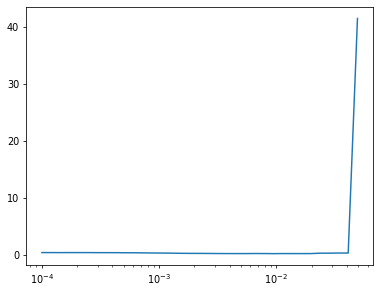

In [23]:
Learner(model, dls, F.mse_loss, cbs=lr_cbs, opt_func=opt_func).lr_find(start_lr=1e-4, gamma=1.2)

In [24]:
model = TinyUnet()

In [25]:
last_res = model.up[-1]
zero_wgts(last_res.convs[-1][-1])
zero_wgts(last_res.idconv[0])
zero_wgts(model.end.convs[-1][-1])

In [26]:
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
learn = Learner(model, dls, F.mse_loss, lr=lr, cbs=cbs+xtra, opt_func=opt_func)

loss,epoch,train
0.167,0,train
0.086,0,eval
0.106,1,train
0.081,1,eval
0.097,2,train
0.079,2,eval
0.094,3,train
0.078,3,eval
0.092,4,train
0.077,4,eval


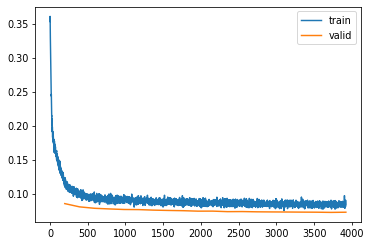

In [27]:
learn.fit(epochs)

loss,epoch,train
0.073,0,eval


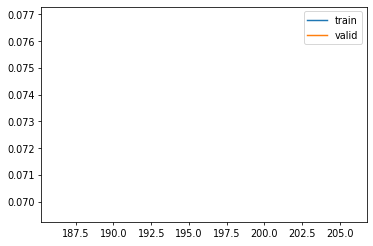

In [29]:
p, t, inp = learn.capture_preds(inps=True)

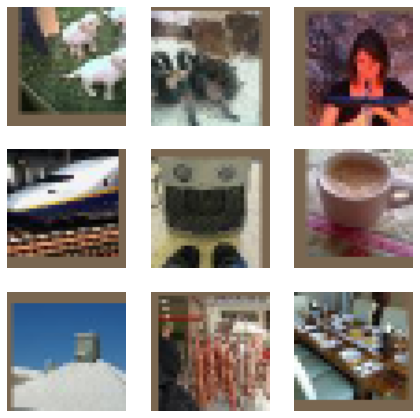

In [30]:
#Inputs
show_images(denorm(inp[:9]), imsize=2.5)

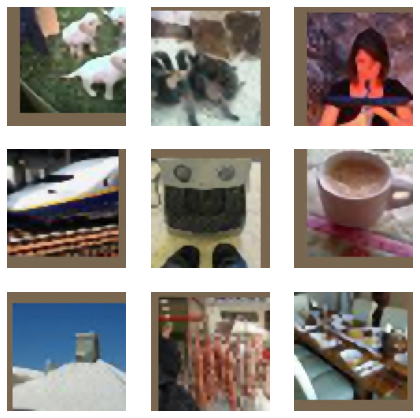

In [31]:
# Outputs
show_images(denorm(p[:9]), imsize=2.5)

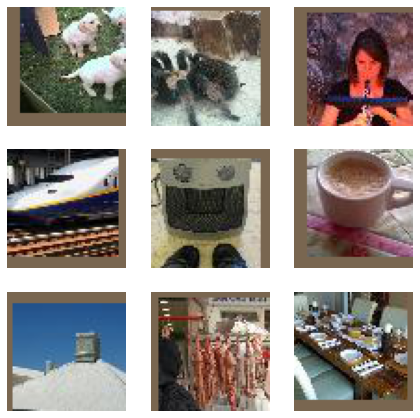

In [32]:
# Training samples.
show_images(denorm(t[:9]), imsize=2.5)

Although we haven't recreated the originals, this approach's outputs are a marked improvement over the autoencoder approach.

However, using MSE as a loss function for a model such as this is incorrect and results in blurry outputs like we saw above. This is a result of averaging the loss during the training steps.

To fix this, **Perceptual Loss** is the recomm